In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
class MNISTDataset(Dataset):
    def __init__(self, train=True):
        self.train = train
        if self.train:
            data = np.loadtxt('/kaggle/input/digit-recognizer/train.csv', delimiter=",", dtype=np.float32, skiprows=1)
        else:
            data = np.loadtxt('/kaggle/input/digit-recognizer/test.csv', delimiter=",", dtype=np.float32, skiprows=1)
        self.x = torch.from_numpy(data[:, 1:])
        self.y = (torch.from_numpy(data[:, 0])).to(torch.long)
        self.n_samples = data.shape[0]

    def __len__(self):
        return self.n_samples

    def __getitem__(self, index):
        if(self.train):
            return self.x[index], self.y[index]
        else:
            return self.x[index]

In [ ]:
train_dataset = MNISTDataset()
train_dataloader = DataLoader(dataset=train_dataset, batch_size=4, shuffle=True)
test_dataset = MNISTDataset(train=False)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [ ]:
'''
dataiter = iter(train_dataloader)
data = next(dataiter)
features, labels = data
print(features, labels)
'''

In [3]:
# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize the data with mean and std of the MNIST dataset
])

In [4]:
# Load the dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 34758289.80it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1044651.46it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9691538.26it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2960915.26it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
class FFNN(nn.Module):
    def __init__(self):
        super(FFNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
model = FFNN()
model.to(device)

FFNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [7]:
# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
# Train the Model
def train(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    return train_loss, train_accuracy

In [9]:
# train(model, train_dataloader, criterion, optimizer)

In [10]:
# Test the model
def test(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = running_loss / len(test_loader)
    test_accuracy = 100 * correct / total
    return test_loss, test_accuracy

In [11]:
num_epochs = 10
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_dataloader, criterion, optimizer)
    test_loss, test_accuracy = test(model, test_dataloader, criterion)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Epoch [1/10], Train Loss: 0.2760, Train Accuracy: 91.77%, Test Loss: 0.1312, Test Accuracy: 95.85%
Epoch [2/10], Train Loss: 0.1124, Train Accuracy: 96.49%, Test Loss: 0.1056, Test Accuracy: 96.81%
Epoch [3/10], Train Loss: 0.0789, Train Accuracy: 97.56%, Test Loss: 0.0947, Test Accuracy: 97.15%
Epoch [4/10], Train Loss: 0.0603, Train Accuracy: 98.11%, Test Loss: 0.0879, Test Accuracy: 97.44%
Epoch [5/10], Train Loss: 0.0498, Train Accuracy: 98.38%, Test Loss: 0.0918, Test Accuracy: 97.36%
Epoch [6/10], Train Loss: 0.0390, Train Accuracy: 98.75%, Test Loss: 0.1013, Test Accuracy: 97.25%
Epoch [7/10], Train Loss: 0.0349, Train Accuracy: 98.80%, Test Loss: 0.0958, Test Accuracy: 97.26%
Epoch [8/10], Train Loss: 0.0290, Train Accuracy: 99.04%, Test Loss: 0.1036, Test Accuracy: 97.44%
Epoch [9/10], Train Loss: 0.0260, Train Accuracy: 99.07%, Test Loss: 0.1135, Test Accuracy: 97.38%
Epoch [10/10], Train Loss: 0.0221, Train Accuracy: 99.26%, Test Loss: 0.0941, Test Accuracy: 97.73%


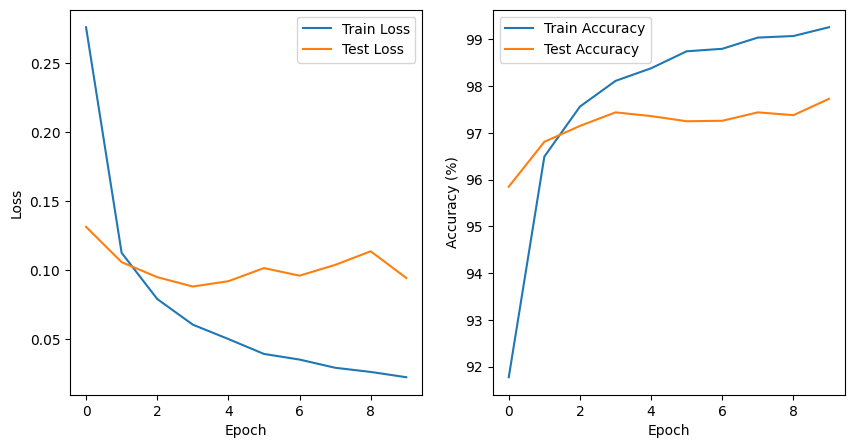

In [12]:
# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

In [ ]:
pip install mlxtend skorch

In [14]:
from mlxtend.evaluate import bias_variance_decomp
from skorch import NeuralNetClassifier

In [17]:
# Convert the dataset to NumPy arrays for skorch compatibility
X_train = train_dataset.data.numpy().reshape(-1, 28*28).astype(np.float32)
y_train = train_dataset.targets.numpy().astype(np.int_)
X_test = test_dataset.data.numpy().reshape(-1, 28*28).astype(np.float32)
y_test = test_dataset.targets.numpy().astype(np.int_)

# Define the skorch wrapper
net = NeuralNetClassifier(
    FFNN,
    max_epochs=5,
    lr=0.001,
    iterator_train__batch_size=64,
    optimizer=torch.optim.Adam,
    criterion=nn.CrossEntropyLoss,
    device=device
)

# Train the skorch model
# Convert the dataset to NumPy arrays for skorch compatibility
X_train = train_dataset.data.numpy().reshape(-1, 28*28).astype(np.float32)
y_train = train_dataset.targets.numpy().astype(np.int_)
X_test = test_dataset.data.numpy().reshape(-1, 28*28).astype(np.float32)
y_test = test_dataset.targets.numpy().astype(np.int_)

# Define the skorch wrapper
net = NeuralNetClassifier(
    FFNN,
    max_epochs=5,
    lr=0.001,
    iterator_train__batch_size=64,
    optimizer=torch.optim.Adam,
    criterion=nn.CrossEntropyLoss,
    device=device
)

# Train the skorch model
net.fit(X_train, y_train)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4319       0.9246        0.2681  2.0886
      2        0.1716       0.9387        0.2288  2.0706
      3        0.1307       0.9453        0.2082  2.1719
      4        0.1137       0.9337        0.2872  2.1472
      5        0.1011       0.9505        0.2173  2.2133


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=FFNN(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=784, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=10, bias=True)
  ),
)

In [ ]:
avg_expected_loss, avg_bias,\
    avg_var = bias_variance_decomp(net,
                                   X_train, y_train,
                                   X_test, y_test,
                                   loss='0-1_loss',
                                   random_seed=23,
                                   epochs=5,
                                  fit_params={'epochs': 0} )
 
# Print the result
print('Average expected loss: %.2f' % avg_expected_loss)
print('Average bias: %.2f' % avg_bias)
print('Average variance: %.2f' % avg_var)